# 🎯 Claim-QA Uncertainty Quantification (Long-Text)

<div style="background-color: rgba(200, 200, 200, 0.1); padding: 20px; border-radius: 8px; margin-bottom: 20px; border: 1px solid rgba(127, 127, 127, 0.2); max-width: 97.5%; overflow-wrap: break-word;">
  <p style="font-size: 16px; line-height: 1.6">
     Claim-QA scorers, adapted as a generalization of long-form semantic entropy, are another method for detecting claim-level or sentence-level hallucinations in long-form LLM outputs. These scorers implement the following steps: decompose responses into granular units (sentences or claims), convert each claim or sentence to a question, sample LLM responses to those questions, and measure consistency among those answers to score the claim. The available scorers and papers from which they are adapted are below:
  </p>
      
*   Long-form Semantic Entropy ([Farquhar et al., 2024](https://www.nature.com/articles/s41586-024-07421-0))
*   Black-Box Generalizations of Long-form Semantic Entropy

</div>

## 📊 What You'll Do in This Demo

<div style="display: flex; margin-bottom: 15px; align-items: center">
  <div style="background-color: #34a853; color: white; border-radius: 50%; width: 30px; height: 30px; display: flex; justify-content: center; align-items: center; margin-right: 15px; flex-shrink: 0"><strong>1</strong></div>
  <div>
    <p style="margin: 0; font-weight: bold"><a href=#section1>Set up LLM and prompts.</a></p>
    <p style="margin: 0; color: rgba(95, 99, 104, 0.8)">Set up LLM instance and load example data prompts.</p>
  </div>
</div>

<div style="display: flex; margin-bottom: 15px; align-items: center">
  <div style="background-color: #34a853; color: white; border-radius: 50%; width: 30px; height: 30px; display: flex; justify-content: center; align-items: center; margin-right: 15px; flex-shrink: 0"><strong>2</strong></div>
  <div>
    <p style="margin: 0; font-weight: bold"><a href=#section2>Generate LLM Responses and Confidence Scores</a></p>
    <p style="margin: 0; color: rgba(95, 99, 104, 0.8)">Generate responses and compute claim-level confidence scores using the <code>LongTextQA()</code> class.</p>
  </div>
</div>

<div style="display: flex; margin-bottom: 25px; align-items: center">
  <div style="background-color: #34a853; color: white; border-radius: 50%; width: 30px; height: 30px; display: flex; justify-content: center; align-items: center; margin-right: 15px; flex-shrink: 0"><strong>3</strong></div>
  <div>
    <p style="margin: 0; font-weight: bold"><a href=#section3>Evaluate Hallucination Detection Performance</a></p>
    <p style="margin: 0; color: rgba(95, 99, 104, 0.8)">Grade claims with `FactScoreGrader` class and evaluate claim-level hallucination detection.</p>
  </div>
</div>

## ⚖️ Advantages & Limitations

<div style="display: flex; gap: 20px">
  <div style="flex: 1; background-color: rgba(0, 200, 0, 0.1); padding: 15px; border-radius: 8px; border: 1px solid rgba(0, 200, 0, 0.2)">
    <h3 style="color: #2e8b57; margin-top: 0">Pros</h3>
    <ul style="margin-bottom: 0">
      <li><strong>Universal Compatibility:</strong> Works with any LLM without requiring token probability access</li>
      <li><strong>Fine-Grained Scoring:</strong> Score at sentence or claim-level to localize likely hallucinations</li>
      <li><strong>Uncertainty-aware decoding:</strong> Improve factual precision by dropping high-uncertainty claims</li>
    </ul>
  </div>
  
  <div style="flex: 1; background-color: rgba(200, 0, 0, 0.1); padding: 15px; border-radius: 8px; border: 1px solid rgba(200, 0, 0, 0.2)">
    <h3 style="color: #b22222; margin-top: 0">Cons</h3>
    <ul style="margin-bottom: 0">
      <li><strong>Higher Cost:</strong> Requires multiple generations per prompt</li>
      <li><strong>Slower:</strong> Multiple generations and comparison calculations increase latency</li>
      <li><strong>Complex:</strong> More complex than simpler methods offered by `LongTextUQ`.</li>
    </ul>
  </div>
</div>

In [1]:
import numpy as np

from uqlm import LongTextQA
from uqlm.utils import load_example_dataset, display_response_refinement, claims_dicts_to_lists, plot_model_accuracies
from uqlm.longform import FactScoreGrader

<a id='section1'></a>
## 1. Set up LLM and Prompts

In this demo, we will illustrate this approach using the [FactScore](https://github.com/shmsw25/FActScore/tree/main/factscore) longform QA dataset. To implement with your use case, simply **replace the example prompts with your data**.  

In [2]:
# Load example dataset (FactScore)
factscore = load_example_dataset("factscore", n=15)[["hundredw_prompt", "wikipedia_text"]].rename(columns={"hundredw_prompt": "prompt"})
factscore.head()

Loading dataset - factscore...
Processing dataset...
Dataset ready!


,prompt,wikipedia_text
0,Tell me a bio of Suthida within 100 words.\n,Suthida Bajrasudhabimalalakshana (Thai: สมเด็จ...
1,Tell me a bio of Miguel Ángel Félix Gallardo w...,"Miguel Ángel Félix Gallardo (born January 8, 1..."
2,Tell me a bio of Iggy Azalea within 100 words.\n,"Amethyst Amelia Kelly (born 7 June 1990), know..."
3,Tell me a bio of Fernando da Costa Novaes with...,"Fernando da Costa Novaes (April 6, 1927 – Marc..."
4,Tell me a bio of Jan Zamoyski within 100 words.\n,Jan Sariusz Zamoyski (Latin: Ioannes Zamoyski ...


In this example, we use `ChatVertexAI` to instantiate our LLM, but any [LangChain Chat Model](https://js.langchain.com/docs/integrations/chat/) may be used. Be sure to **replace with your LLM of choice.**

In [3]:
from langchain_google_vertexai import ChatVertexAI

gemini_flash = ChatVertexAI(model="gemini-2.5-flash")
gemini_flash_lite = ChatVertexAI(model="gemini-2.5-flash-lite")

<a id='section2'></a>
## 2. Generate LLM Responses and Claim/Sentence-Level Confidence Scores

### `LongTextQA()` - Generate long-text LLM responses, decompose into claims or sentences, create questions for which those claims are the answers, and measure consistency in LLM responses to those questions.

![Sample Image](https://raw.githubusercontent.com/cvs-health/uqlm/develop/assets/images/claim_qa_graphic.png)

#### 📋 Class Attributes

<table style="border-collapse: collapse; width: 100%; border: 1px solid rgba(127, 127, 127, 0.2);">
  <tr>
    <th style="background-color: rgba(200, 200, 200, 0.2); width: 20%; padding: 8px; text-align: left; border: 1px solid rgba(127, 127, 127, 0.2);">Parameter</th>
    <th style="background-color: rgba(200, 200, 200, 0.2); width: 25%; padding: 8px; text-align: left; border: 1px solid rgba(127, 127, 127, 0.2);">Type & Default</th>
    <th style="background-color: rgba(200, 200, 200, 0.2); width: 55%; padding: 8px; text-align: left; border: 1px solid rgba(127, 127, 127, 0.2);">Description</th>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">llm</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">BaseChatModel<br><code>default=None</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">A langchain llm `BaseChatModel`. User is responsible for specifying temperature and other relevant parameters to the constructor of the provided `llm` object.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">granularity</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">str<br><code>default="claim"</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies whether to decompose and score at claim or sentence level granularity. Must be either "claim" or "sentence".</td>
  </tr>  
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">scorers</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">List[str]<br><code>default=None</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies which black box (consistency) scorers to include. Must be subset of ['semantic_negentropy', 'noncontradiction', 'exact_match', 'bert_score', 'cosine_sim', 'entailment', 'semantic_sets_confidence']. If None, defaults to ["entailment"].</td>
  </tr>    
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">aggregation</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">str<br><code>default="mean"</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies how to aggregate claim/sentence-level scores to response-level scores. Must be one of 'min' or 'mean'.</td>
  </tr>  
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">response_refinement</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">bool<br><code>default=False</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies whether to refine responses with uncertainty-aware decoding. This approach removes claims with confidence scores below the response_refinement_threshold and uses the claim_decomposition_llm to reconstruct the response from the retained claims. For more details, refer to Jiang et al., 2024: https://arxiv.org/abs/2410.20783</td>
  </tr>  
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">claim_filtering_scorer</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Optional[str]<br><code>default=None</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies which scorer to use to filter claims if response_refinement is True. If not provided, defaults to the first element of self.scorers.</td>
  </tr>    
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">claim_decomposition_llm</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">BaseChatModel<br><code>default=None</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">A langchain llm `BaseChatModel` to be used for decomposing responses into individual claims. Also used for claim refinement. If granularity="claim" and claim_decomposition_llm is None, the provided `llm` will be used for claim decomposition.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">question_generator_llm</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">BaseChatModel<br><code>default=None</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">A langchain llm `BaseChatModel` to be used for decomposing responses into individual claims. Used for generating questions from claims or sentences in claim-QA approach. If None, defaults to claim_decomposition_llm.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">device</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">str or torch.device<br><code>default=None</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies the device that NLI model use for prediction. If None, detects and returns the best available PyTorch device. Prioritizes CUDA (NVIDIA GPU), then MPS (macOS), then CPU.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">system_prompt</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">str or None<br><code>default="You are a helpful assistant."</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Optional argument for user to provide custom system prompt for the LLM.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">max_calls_per_min</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">int<br><code>default=None</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies how many API calls to make per minute to avoid rate limit errors. By default, no limit is specified.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">use_n_param</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">bool<br><code>default=False</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies whether to use <code>n</code> parameter for <code>BaseChatModel</code>. Not compatible with all <code>BaseChatModel</code> classes. If used, it speeds up the generation process substantially when <code>num_responses</code> is large.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">sampling_temperature</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">float<br><code>default=1</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">The 'temperature' parameter for LLM to use when generating sampled LLM responses. Must be greater than 0.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">nli_model_name</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">str<br><code>default="microsoft/deberta-large-mnli"</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies which NLI model to use. Must be acceptable input to <code>AutoTokenizer.from_pretrained()</code> and <code>AutoModelForSequenceClassification.from_pretrained()</code>.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">max_length</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">int<br><code>default=2000</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies the maximum allowed string length for LLM responses for NLI computation. Responses longer than this value will be truncated in NLI computations to avoid <code>OutOfMemoryError</code>.</td>
  </tr>
</table>

#### 🔍 Parameter Groups

<div style="display: flex; gap: 20px; margin-bottom: 20px">
  <div style="flex: 1; padding: 10px; background-color: rgba(0, 100, 200, 0.1); border-radius: 5px; border: 1px solid rgba(0, 100, 200, 0.2);">
    <p style="font-weight: bold">🧠 LLM-Specific</p>
    <ul>
      <li><code>llm</code></li>
      <li><code>system_prompt</code></li>
      <li><code>sampling_temperature</code></li>
    </ul>
  </div>
  <div style="flex: 1; padding: 10px; background-color: rgba(0, 200, 0, 0.1); border-radius: 5px; border: 1px solid rgba(0, 200, 0, 0.2);">
    <p style="font-weight: bold">📊 Confidence Scores</p>
    <ul>
      <li><code>granularity</code></li>
      <li><code>scorers</code></li>
      <li><code>aggregation</code></li>
      <li><code>num_questions</code></li>
      <li><code>num_claim_qa_responses</code></li>
      <li><code>response_refinement</code></li>        
      <li><code>response_refinement_threshold</code></li>  
    </ul>
  </div>
  <div style="flex: 1; padding: 10px; background-color: rgba(200, 150, 0, 0.1); border-radius: 5px; border: 1px solid rgba(200, 150, 0, 0.2);">
    <p style="font-weight: bold">🖥️ Hardware</p>
    <ul>
      <li><code>device</code></li>
    </ul>
  </div>
  <div style="flex: 1; padding: 10px; background-color: rgba(200, 0, 200, 0.1); border-radius: 5px; border: 1px solid rgba(200, 0, 200, 0.2);">
    <p style="font-weight: bold">⚡ Performance</p>
    <ul>
      <li><code>max_calls_per_min</code></li>
      <li><code>use_n_param</code></li>
    </ul>
  </div>
</div>

```

In [4]:
claimqa = LongTextQA(
    llm=gemini_flash,
    question_generator_llm=gemini_flash,
    aggregation="mean",  # switch to 'min' for more conservative scoring
    response_refinement=True,  # whether to filter out low-confidence claims
    scorers=["noncontradiction"],
    # max_calls_per_min=1000,
)

claim_filtering_scorer is not specified for response_refinement. Defaulting to noncontradiction.


### 🔄 Class Methods

<table style="border-collapse: collapse; width: 100%; border: 1px solid rgba(127, 127, 127, 0.2);">
  <tr>
    <th style="background-color: rgba(200, 200, 200, 0.2); width: 25%; padding: 8px; text-align: left; border: 1px solid rgba(127, 127, 127, 0.2);">Method</th>
    <th style="background-color: rgba(200, 200, 200, 0.2); width: 75%; padding: 8px; text-align: left; border: 1px solid rgba(127, 127, 127, 0.2);">Description & Parameters</th>
  </tr>
  <tr>
    <td style="font-weight: bold; vertical-align: top; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">BlackBoxUQ.generate_and_score</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">
      <p>Generate LLM responses, sampled LLM (candidate) responses, and compute confidence scores for the provided prompts.</p>
      <p><strong>Parameters:</strong></p>
      <ul>
        <li><code>prompts</code> - (<strong>List[str] or List[List[BaseMessage]]</strong>) A list of input prompts for the model.</li>
        <li><code>num_questions</code> - (<strong>int, default=2</strong>) Specifies how many questions to generate per claim/sentence.</li>
        <li><code>num_claim_qa_responses</code> - (<strong>int, default=5</strong>) Specifies how many sampled responses to generate per claim/sentence question.</li>        
        <li><code>response_refinement_threshold</code> - (<strong>float, default=1/3</strong>) Threshold for uncertainty-aware filtering. Claims with confidence scores below this threshold are dropped from the refined response. Only used if response_refinement is True.</li> 
        <li><code>show_progress_bars</code> - (<strong>bool, default=True</strong>) If True, displays a progress bar while generating and scoring responses.</li>        
      </ul>
      <p><strong>Returns:</strong> <code>UQResult</code> containing data (prompts, responses, sampled responses, and confidence scores) and metadata</p>
      <div style="background-color: rgba(0, 200, 0, 0.1); padding: 8px; border-radius: 3px; margin-top: 10px; border: 1px solid rgba(0, 200, 0, 0.2); margin-right: 5px; box-sizing: border-box; width: 100%;">
        <strong>💡 Best For:</strong> Complete end-to-end uncertainty quantification when starting with prompts.
      </div>
    </td>
  </tr>
  <tr>
    <td style="font-weight: bold; vertical-align: top; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">BlackBoxUQ.score</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">
      <p>Compute confidence scores on provided LLM responses. Should only be used if responses and sampled responses are already generated.</p>
      <p><strong>Parameters:</strong></p>
      <ul>
        <li><code>prompts</code> - (<strong>List[str]</strong>) A list of input prompts for the model.</li>
        <li><code>responses</code> - (<strong>List[str]</strong>) A list of LLM responses for the prompts.</li>
        <li><code>num_questions</code> - (<strong>int, default=2</strong>) Specifies how many questions to generate per claim/sentence.</li>
        <li><code>num_claim_qa_responses</code> - (<strong>int, default=5</strong>) Specifies how many sampled responses to generate per claim/sentence question.</li>       
        <li><code>response_refinement_threshold</code> - (<strong>float, default=1/3</strong>) Threshold for uncertainty-aware filtering. Claims with confidence scores below this threshold are dropped from the refined response. Only used if response_refinement is True.</li> 
        <li><code>show_progress_bars</code> - (<strong>bool, default=True</strong>) If True, displays a progress bar while scoring responses.</li>  
      </ul>
      <p><strong>Returns:</strong> <code>UQResult</code> containing data (responses, sampled responses, and confidence scores) and metadata</p>
      <div style="background-color: rgba(0, 200, 0, 0.1); padding: 8px; border-radius: 3px; margin-top: 10px; border: 1px solid rgba(0, 200, 0, 0.2); margin-right: 5px; box-sizing: border-box; width: 100%;">
        <strong>💡 Best For:</strong> Computing uncertainty scores when responses are already generated elsewhere.
      </div>
    </td>
  </tr>
</table>

In [5]:
results = await claimqa.generate_and_score(prompts=factscore.prompt.to_list(), response_refinement_threshold=0.85)

Output()

In [6]:
result_df = results.to_df()
result_df.head(5)

,prompt,response,noncontradiction,claims_data,refined_response,refined_noncontradiction
0,Tell me a bio of Suthida within 100 words.\n,Queen Suthida Bajrasudhabimalalakshana is the ...,0.872727,[{'claim': 'Queen Suthida Bajrasudhabimalalaks...,"Queen Suthida Bajrasudhabimalalakshana, the cu...",0.985608
1,Tell me a bio of Miguel Ángel Félix Gallardo w...,"Miguel Ángel Félix Gallardo, known as ""El Padr...",0.922575,[{'claim': 'Miguel Ángel Félix Gallardo was kn...,"Miguel Ángel Félix Gallardo, famously known as...",0.973158
2,Tell me a bio of Iggy Azalea within 100 words.\n,"Amethyst Amelia Kelly, known professionally as...",0.895390,[{'claim': 'Amethyst Amelia Kelly is known pro...,"Amethyst Amelia Kelly, known professionally as...",0.986233
3,Tell me a bio of Fernando da Costa Novaes with...,Fernando da Costa Novaes (1942-2004) was a hig...,0.797684,[{'claim': 'Fernando da Costa Novaes was born ...,Fernando da Costa Novaes was a highly influent...,0.966738
4,Tell me a bio of Jan Zamoyski within 100 words.\n,Jan Zamoyski (1542–1605) was a preeminent Poli...,0.947813,"[{'claim': 'Jan Zamoyski was born in 1542.', '...","Jan Zamoyski, born in 1542 and dying in 1605, ...",0.978016


#### Response refinement

Response refinement works by dropping claims with confidence scores (specified with `claim_filtering_scorer`) below a specified threshold (specified with `response_refinement_threshold`) and reconstructing the response from the retained claims.

![Sample Image](https://raw.githubusercontent.com/cvs-health/uqlm/develop/assets/images/uad_graphic.png)

To illustrate how the response refinement operates, let's view an example. We first view the fine-grained claim-level data, including the claims in the original response, the claim-level confidence scores, and whether each claim was removed during the response refinement process. 

In [7]:
# View fine-grained claim data for a response
result_df.claims_data[0]

[{'claim': 'Queen Suthida Bajrasudhabimalalakshana is the current Queen of Thailand.',
  'removed': False,
  'claim_questions': ['Who is the current Queen of Thailand?'],
  'claim_qa_responses': ['Suthida.'],
  'claim_qa_sampled_responses': [['Suthida.',
    'Suthida.',
    'Suthida.',
    'Suthida.',
    'Suthida']],
  'noncontradiction': 0.997577428817749},
 {'claim': 'Queen Suthida Bajrasudhabimalalakshana was born Suthida Tidjai.',
  'removed': True,
  'claim_questions': ["What was Queen Suthida Bajrasudhabimalalakshana's birth name?"],
  'claim_qa_responses': ['Suthida Tidjai'],
  'claim_qa_sampled_responses': [['Nui-Ngam',
    'Suthida Tidjai',
    'Suthida Tidjai',
    'Suthida Tidjai',
    'Suthida Tidjai']],
  'noncontradiction': 0.8045254647731781},
 {'claim': 'Queen Suthida Bajrasudhabimalalakshana began her career as a flight attendant.',
  'removed': False,
  'claim_questions': ["What was Queen Suthida Bajrasudhabimalalakshana's first career?"],
  'claim_qa_responses': ['F

We can examine a particular claim in the response that was removed because its confidence score was too low. Let's see how this is reflected in the original vs. the refined response. 

In [8]:
display_response_refinement(original_text=result_df.response[0], claims_data=result_df.claims_data[0], refined_text=result_df.refined_response[0])

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Response Refinement Example

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

╭─────────────────────────────────────────────── Original Response ───────────────────────────────────────────────╮
│ Queen Suthida Bajrasudhabimalalakshana is the current Queen of Thailand. Born Suthida Tidjai, she began her     │
│ career as a flight attendant for Thai Airways International. She later joined the Royal Thai Army, rising       │
│ through its ranks, and served in the Royal Security Command. In 2017, she was made a full General. She became a │
│ consort to King Vajiralongkorn (Rama X) and married him on May 1, 2019, becoming Queen just days before his     │
│ official coronation. She is an influential figure in the Thai monarchy.                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────── Low-Confidence Claims to be Removed ──────────────────────────────────────╮
│ • Queen Suthida Bajrasudhabimalalakshana was born Suthida Tidjai.                                               │
│ • Queen Suthida Bajrasudhabimalalakshana joined the Royal Thai Army.                                            │
│ • Queen Suthida Bajrasudhabimalalakshana rose through the ranks of the Royal Thai Army.                         │
│ • Queen Suthida Bajrasudhabimalalakshana served in the Royal Security Command.                                  │
│ • Queen Suthida Bajrasudhabimalalakshana became a consort to King Vajiralongkorn.                               │
│ • King Vajiralongkorn is also known as Rama X.                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── Refined Response ────────────────────────────────────────────────╮
│ Queen Suthida Bajrasudhabimalalakshana, the current and influential Queen of Thailand, began her career as a    │
│ flight attendant for Thai Airways International. Her diverse background also includes a military role, as she   │
│ was made a full General in 2017. She officially married King Vajiralongkorn on May 1, 2019, becoming Queen just │
│ days before his official coronation.                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

<a id='section3'></a>
## 3. Evaluate Hallucination Detection Performance

To evaluate hallucination detection performance, we 'grade' the atomic claims in the responses against an answer key. Here, we use UQLM's out-of-the-box `FactScoreGrader`, which can be used with [LangChain Chat Model](https://js.langchain.com/docs/integrations/chat/). **If you are using your own prompts/questions, be sure to update the grading method accordingly**.

In [9]:
# set up the LLM grader
grader = FactScoreGrader(llm=gemini_flash)

Before grading, we need to have claims formatted in list of lists where each interior list corresponds to a generated response. 

In [10]:
# Convert claims to list of lists
claims_data_lists = claims_dicts_to_lists(result_df.claims_data.tolist())

In [11]:
# grade original responses against the answer key using the grader
result_df["claim_grades"] = await grader.grade_claims(claim_sets=claims_data_lists["claim"], answers=factscore["wikipedia_text"].to_list())
result_df["answer"] = factscore["wikipedia_text"]
result_df.head(5)

,prompt,response,noncontradiction,claims_data,refined_response,refined_noncontradiction,claim_grades,answer
0,Tell me a bio of Suthida within 100 words.\n,Queen Suthida Bajrasudhabimalalakshana is the ...,0.872727,[{'claim': 'Queen Suthida Bajrasudhabimalalaks...,"Queen Suthida Bajrasudhabimalalakshana, the cu...",0.985608,"[True, True, True, True, False, False, True, F...",Suthida Bajrasudhabimalalakshana (Thai: สมเด็จ...
1,Tell me a bio of Miguel Ángel Félix Gallardo w...,"Miguel Ángel Félix Gallardo, known as ""El Padr...",0.922575,[{'claim': 'Miguel Ángel Félix Gallardo was kn...,"Miguel Ángel Félix Gallardo, famously known as...",0.973158,"[True, True, True, True, True, True, True, Tru...","Miguel Ángel Félix Gallardo (born January 8, 1..."
2,Tell me a bio of Iggy Azalea within 100 words.\n,"Amethyst Amelia Kelly, known professionally as...",0.895390,[{'claim': 'Amethyst Amelia Kelly is known pro...,"Amethyst Amelia Kelly, known professionally as...",0.986233,"[True, True, True, False, True, True, True, Tr...","Amethyst Amelia Kelly (born 7 June 1990), know..."
3,Tell me a bio of Fernando da Costa Novaes with...,Fernando da Costa Novaes (1942-2004) was a hig...,0.797684,[{'claim': 'Fernando da Costa Novaes was born ...,Fernando da Costa Novaes was a highly influent...,0.966738,"[False, True, False, False, False, False, Fals...","Fernando da Costa Novaes (April 6, 1927 – Marc..."
4,Tell me a bio of Jan Zamoyski within 100 words.\n,Jan Zamoyski (1542–1605) was a preeminent Poli...,0.947813,"[{'claim': 'Jan Zamoyski was born in 1542.', '...","Jan Zamoyski, born in 1542 and dying in 1605, ...",0.978016,"[True, True, True, True, True, True, True, Tru...",Jan Sariusz Zamoyski (Latin: Ioannes Zamoyski ...


In [12]:
all_claim_scores, all_claim_grades = [], []
for i in range(len(result_df)):
    all_claim_scores.extend(claims_data_lists["noncontradiction"][i])
    all_claim_grades.extend(result_df["claim_grades"][i])

print(f"""Baseline LLM accuracy: {np.mean(all_claim_grades)}""")

Baseline LLM accuracy: 0.6322751322751323


#### 3.1 Claim-Level Hallucination Detection AUROC

To evaluate fine-grained hallucination detection performance, we compute AUROC of claim-level hallucination detection. Below, we plot the ROC curve and report these results.

In [24]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_true=all_claim_grades, y_score=all_claim_scores)
roc_auc = roc_auc_score(y_true=all_claim_grades, y_score=all_claim_scores)

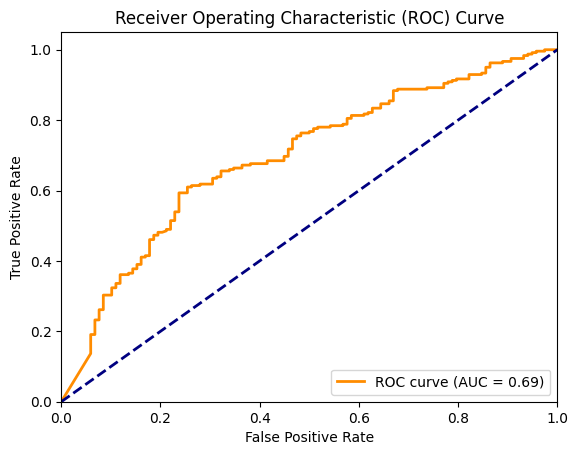

In [25]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

#### 3.2 Gains from Uncertainty-Aware Decoding

Lastly, we evaluate the gains from uncertainty-aware decoding (UAD) by measuring the factual precision over claims at various filtering thresholds. 

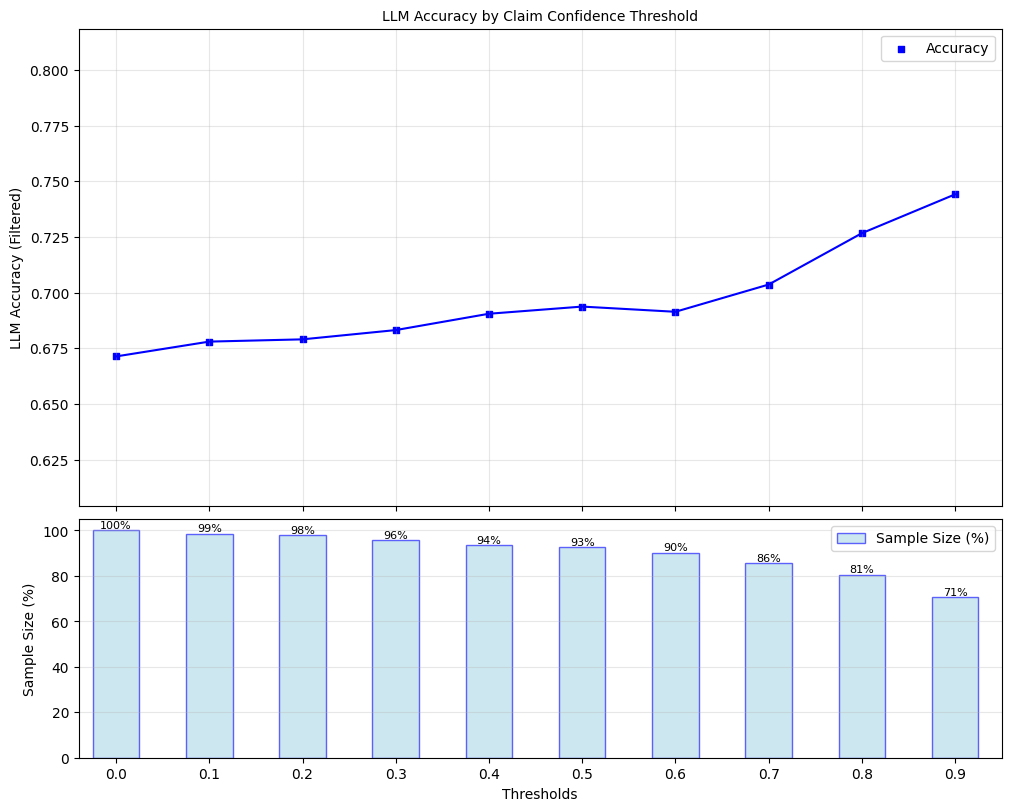

In [27]:
plot_model_accuracies(scores=all_claim_scores, correct_indicators=all_claim_grades, title="LLM Accuracy by Claim Confidence Threshold", display_percentage=True)

Since, we have selected a threshold of 0.85, we can measure LLM accuracy with and without UAD.

In [30]:
thresh = 0.85
filtered_grades, filtered_scores = [], []
for grade, score in zip(all_claim_grades, all_claim_scores):
    if score > thresh:
        filtered_grades.append(grade)
        filtered_scores.append(score)

print(f"Baseline LLM factual precision: {np.mean(all_claim_grades)}")
print(f"UAD-Improved LLM factual precision: {np.mean(filtered_grades)}")

Baseline LLM factual precision: 0.6713091922005571
UAD-Improved LLM factual precision: 0.7306273062730627


<a id='section4'></a>
## 4. Scorer Definitions

Long-form uncertainty quantification implements a three-stage pipeline after response generation:

1. Response Decomposition: The response $y$ is decomposed into units (claims or sentences), where a unit as denoted as $s$.

2. Unit-Level Confidence Scoring: Confidence scores are computed using function $c_g(s;\cdot) \in [0, 1]$. Higher scores indicate greater likelihood of factual correctness. Units with scores below threshold $\tau$ are flagged as potential hallucinations.

3. Response-Level Aggregation: Unit scores are combined to provide an overall response confidence.

The Claim-QA approach demonstrated here is adapted from [Farquhar et al., 2024](https://www.nature.com/articles/s41586-024-07421-0). It uses an LLM to convert each unit (sentence or claim) into a question for which that unit would be the answer. The method measures consistency across multiple responses to these questions, effectively applying standard black-box uncertainty quantification to those sampled responses to the unit questions. Formally, a claim-QA scorer $c_g(s;\cdot)$ is defined as follows:

$$c_g(s; y_0^{(s)}, \mathbf{y}^{(s)}_{\text{cand}}) = \frac{1}{m} \sum_{j=1}^m \eta(y_0^{(s)}, y_j^{(s)})$$

where $y_0^{(s)}$ is the original unit response, $\mathbf{y}^{(s)}_{\text{cand}} = \{y_1^{(s)}, ..., y_m^{(s)}\}$ are $m$ candidate responses to the unit's question, and $\eta$ is a consistency function such as contradiction probability, cosine similarity, or BERTScore F1. Semantic entropy, which follows a slightly different functional form, can also be used to measure consistency.

© 2025 CVS Health and/or one of its affiliates. All rights reserved.